#  Robust recognition and exploratory analysis of crystal structures via Bayesian deep learning

In the following, we will explain all the necessary steps, with code examples, to use AI-SYM for crystal-structure recognition in single- and polycyrstalline systems using the ai4materials python package. For additional details, please refer to 

[1] AI-SYM: A. Leitherer, A. Ziletti, and L. M. Ghiringhelli, arxiV:??, (2021)

[//]: <> ([2] ai4materials: A. Leitherer, A.Ziletti, and L. M. Ghiringhelli, https://joss.theoj.org/papers ?)


For a better overview, we provide an outline for the tutorial:

* Quickstart (jump here if you want to directly use ARISE)
* Single-Crystal classification
* Polycyrstal classification
* Unsupervised learning (including exploratory analysis tools)

In [1]:
import ase
from ase.io import read
from ase.visualize import view

from timeit import default_timer as timer

from collections import defaultdict


from ai4materials.utils.utils_crystals import get_nn_distance, scale_structure
from ai4materials.descriptors.quippy_soap_descriptor import quippy_SOAP_descriptor
from ai4materials.utils.utils_config import set_configs, setup_logger
from ai4materials.models.cnn_polycrystals import predict_with_uncertainty
from ai4materials.models import AI_SYM

import quippy
from quippy import Atoms as quippy_Atoms
from quippy import descriptors

import matplotlib.pyplot as plt

import os

import numpy as np

from keras.models import load_model

import json
import pickle

# filepaths
geometry_files = './geometry_files'
prototype_path = './geometry_files/single_crystals/AI_SYM_paper/PROTOTYPES'
bcc_prototype_path = os.path.join(prototype_path, 
                                  'Elemental_solids',
                                  'bcc_W_A_cI2_229_a',
                                  'bcc_W_A_cI2_229_a.txt' )

NaCl_prototype_path = os.path.join(prototype_path, 
                                  'Binaries',
                                  'RockSalt_NaCl',
                                  'RockSalt_NaCl.txt' )

nn_model_path = './data/nn_model/AI_SYM_Leitherer_et_al_2021.h5'
nn_model_class_info_path = './data/nn_model'



/usr/local/lib/python2.7/dist-packages/pymatgen/__init__.py:87: UserWarning: 
Pymatgen will drop Py2k support from v2019.1.1. Pls consult the documentation
at https://www.pymatgen.org for more details.
  at https://www.pymatgen.org for more details.""")
/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Quickstart

Please specify the geometry files that you want to analyze in the list 'geometry_files'.

ARISE can be used in two modes: Local and global (controlled via the keyword 'mode'). 

If mode = 'local', then stride and box size need to be defined (standard setting: stride=1.0, box_size=12.0).

In [2]:
"""
from ai4materials.models import ARISE

geometry_files = [ ... ]

predictions, uncertainty = AI_SYM.analyze(geometry_files, mode='global') 

predictions, uncertainty = AI_SYM.analyze(geometry_files, mode='local',
                                          stride=1.0, box_size=12.0)
"""

"\nfrom ai4materials.models import AI_SYM\n\ngeometry_files = [ ... ]\n\npredictions, uncertainty = AI_SYM.analyze(geometry_files, mode='global') \n\npredictions, uncertainty = AI_SYM.analyze(geometry_files, mode='local',\n                                          stride=1.0, box_size=12.0)\n"

Typically, one uses the global mode for single crystals an the local mode for large (polycrystalline) samples (too zoom into and detect structural defects such as grain boundaries). However, one can also mix this up and investigate, for instance, the global assignments  for polycrystals (see for instance the analysis of STEM graphene images with grain boundaries in Fig. 3 of Ref. [1]).

The following sections provide more details on how exactly this method works. 

## The Bayesian-deep-learning model

Given an unknown atomic structure, the goal is to find the most similar prototype (that is currently known to be found in nature, for example). Here, this list includes fcc, bcc, diamond, and hcp symmetry but as we will see later, our frameworks allows to treat a much broader range of materials.

![](./assets/cs_classification_first_example.svg)

The initial input that describes a given atomic structure (single- or polycyrstalline) are atomic positions, chemical species symbols (and lattice vectors for periodic systems).

The first step is to lay down how this input will be treated in the AI-SYM framework, i.e., how we arrive at a meaningful prediction.

Considering exemplarily  the body-centered cubic system (see http://www.aflowlib.org/prototype-encyclopedia/A_cI2_229_a.html), we describe in the following the prediction pipeline for single crystals that is schematically summarized in the following figure:
![](./assets/concept_figure_global.svg)

We first load the geometry file using ASE (https://wiki.fysik.dtu.dk/ase/index.html). We typically use the aims format for the geometry files (while compatibility with many other formats is provided due to the use of ASE https://wiki.fysik.dtu.dk/ase/index.html for parsing geometry files). 

In [3]:
structure = read(bcc_prototype_path, ':', 'aims')[0]
# view(structure, viewer='x3d')

To avoid dependence on the lattice parameters, we isotropically scale the structure using the function 'get_nn_distance' from the ai4materials package, where by default, we compute the radial distribution function (as approximated by the histogram of nearest neighbor distances) and then choose the center of the maximally populated bin as the nearest neighbor distance (i.e., the mode):

In [4]:
scale_factor = get_nn_distance(structure)
print('Scale factor for fcc structure = {}'.format(scale_factor))

DEBUG:ai4materials:List of neighbors of atom number 0


Scale factor for fcc structure = 2.73731014894


Given an atomic structure, scaling of atomic positions and unit cell is summarized in the function 'scale_structure' (see ai4materials docs for the definition of all keywords).  Before we conduct this calculation, we discuss the logging feature of ai4materials. Specifically, we define a configuration object, that introduces a specific folder structure. 

Specifically, three different folders are created automatically:
* 'desc_folder': Here the descriptors that we are going to calculate later will be saved (as  file_name.tar.gz)
* 'tmp_folder': temporary folder in which individual files that are calculated will be temporarily saved and later merged into .tar.gz files and moved to 'desc_folder'
* 'results': folder where some of the results are saved.

In practice, you only need to define the main folder in which the calculations should be saved. Here we choose the same path as the tutorial notebook:

In [5]:
# set config file
main_folder = os.getcwd()
configs = set_configs(main_folder=main_folder)

Now we define a logger object, depending on the configuration:

In [6]:
logger = setup_logger(configs, level='INFO', display_configs=False)

You can see that the logger defined at the very beginning of this tutorial provides you with some information on the calculation steps being performed. You can adapt this by setting the level of the logger object, where the levels are defined as (see https://docs.python.org/3/library/logging.html#levels):

* CRITICAL = 50
* ERROR = 40
* WARNING = 30
* INFO = 20
* DEBUG = 10
* NOTSET = 0

Depending on your choice, different levels of details will be saved to file (into the 'tmp_folder' as 'output.log')

In [7]:
print('Previous logger level = {}'.format(logger.level))
logger.setLevel('INFO')
print('New logger level = {}'.format(logger.level))

Previous logger level = 20
New logger level = 20


Now we calculate the scaling using the function 'scale_structure' with the most important steps (depending on the logger level) being printed out:

In [8]:
scaled_structure = scale_structure(structure, scaling_type='quantile_nn',
                                   atoms_scaling_cutoffs=[10., 20., 30., 40.],
                                   extrinsic_scale_factor=1.0,
                                   element_sensitive=False, 
                                   central_atom_species=structure.get_atomic_numbers()[0],
                                   neighbor_atoms_species=structure.get_atomic_numbers()[0],
                                   constrain_nn_distances=False)

INFO: Scale factor: 2.73731014894


2.737310148939904


Using atomic positions $\mathbf{r}_i$ labeled by chemical species $c_i$ ($i = 1, ..., \text{N}_{\text{atoms}}$) directly as input to a classification model introduces several issues. Most importantly, physically meaningful invariances that we know to be true are not respected (translational / rotational invariance and permutations of idential atoms). Also the input dimension would depend on the number of atoms (while this could be tackled with the use of convolutional neural networks).

A well-known and -tested materials science descriptor that captures physical invariances is the so-called  SOAP descriptor [3-5].  In this tutorial we will employ the SOAP implementaion that is being made available via the quippy package (https://github.com/libAtoms/QUIP) for non-commercial use. Note that ai4materials also contains an interface to the Dscribe package (https://singroup.github.io/dscribe/latest/).

In short, given an atomic structure with N atoms, we obtain N SOAP vectors (respecting the mentioned invariances) that represent the local atomic environments of each atom. The local atomic environments of an atom is defined as a sphere (centered at that particular atom) that has a certain (tunable) cutoff radius $R_C$. Each atom within that sphere is represented by a Gaussian function (with a certain, tunable width $\sigma$) and the sum of these Gaussians defines the local density:

$\begin{equation}  \rho_\mathscr{X}(\vec{r})=\sum_{i\in \mathscr{X}} \exp{\left(-\frac{(\vec{r}-\vec{r}_i)^2}{2\sigma^2}\right)} \end{equation}$

The local density is expanded in terms of radial basis functions and spherical harmonics, giving a set of basis set expansion coefficients $c_{blm}$:
$\begin{equation}  \rho_\mathscr{X}(\vec{r})=\sum_{i\in \mathscr{X}} \exp{\left(-\frac{(\vec{r}-\vec{r}_i)^2}{2\sigma^2}\right)} =\sum_{blm}c_{blm}u_b(r) Y_{lm}(\hat{\vec{r}}) \end{equation}$


A rotational average of these coefficients  yields the SOAP representation of the original local atomic environment:

$\begin{equation}
 p(\mathscr{X})_{b_1b_2l}=\pi\sqrt{\frac{8}{2l+1}}\sum_{m}(c_{b_1 lm})^{\dagger} c_{b_2 lm}.
\end{equation}$

Applying this procedure to every atom, gives a collection of SOAP vectors, which one may average. The default behaviour in quippy is though to average the coefficients and then perform the rotational average.

We adapt the raw output of quippy using a typical averaging procedure (while additional details such as the treatment of "cross-correlation terms" is discussed in the supplementary material of [1]).

We first have to define some parameters that define the SOAP descriptor and are summarized in the string 
descriptor_options that is used to create the SOAP descritptor object:

In [9]:
cutoff = 4.0
central_weight = 0.0
atom_sigma = 0.1
p_b_c = True

l_max = 6
n_max = 9
n_Z = 1
n_species = 1
species_Z = structure.get_atomic_numbers()[0]
Z = structure.get_atomic_numbers()[0]
average = True

descriptor_options = 'soap '+'cutoff='+str(cutoff)+' l_max='+str(l_max)+' n_max='+str(n_max) + \
                     ' atom_sigma='+str(atom_sigma)+ ' n_Z='+str(n_Z) + \
                     ' Z={'+str(Z)+'} n_species='+str(n_species)+' species_Z={'+str(species_Z) + \
                     '} central_weight='+str(central_weight)+' average='+str(average)
            
desc = descriptors.Descriptor(descriptor_options)
struct = quippy_Atoms(scaled_structure)
struct.set_pbc(p_b_c)

Now we can calculate the SOAP descriptor and plot its components:

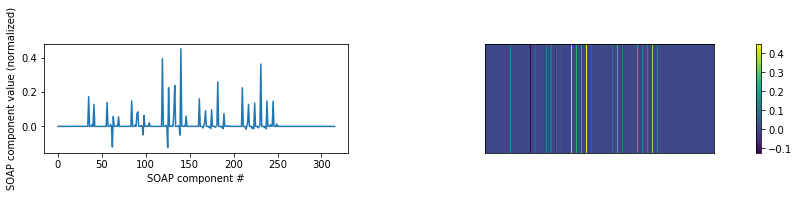

In [10]:
#Compute SOAP descriptor
struct.set_cutoff(desc.cutoff())
struct.calc_connect()
SOAP_descriptor = desc.calc(struct)['descriptor']

# visualize descriptor
def vis_desc(SOAP_descriptor):
    fig, ax = plt.subplots(1,2, figsize=(15,2))
    ax[0].plot(SOAP_descriptor[0])
    ax[0].set_xlabel('SOAP component #')
    ax[0].set_ylabel('SOAP component value (normalized)')


    m = ax[1].imshow(SOAP_descriptor, aspect=150, cmap="viridis", extent=[0, 315, 0, 1])
    ax[1].set_yticks([])
    ax[1].set_xticks([])
    fig.colorbar(m, ax=ax)


    plt.show()
vis_desc(SOAP_descriptor)

All these steps are summarized in the ai4materials package and the SOAP descriptor for a general structure can be obtained the following way:

INFO: Metadata for descriptor quippy_SOAP_descriptor: [u'quippy_SOAP', u'quippy_SOAP_image', u'quippy_SOAP_coordinates']
INFO: Structure: Atoms(symbols='W', pbc=True, cell=[[-1.5775, 1.5775, 1.5775], [1.5775, -1.5775, 1.5775], [1.5775, 1.5775, -1.5775]])
INFO: Scale factor: 2.73731014894


[ True  True  True]
2.737310148939904


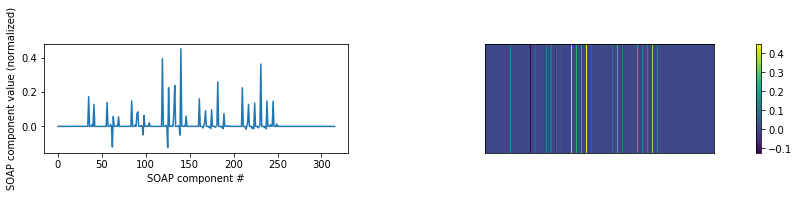

In [11]:
# Define the descriptor
descriptor = quippy_SOAP_descriptor()

soap_desc = descriptor.calculate(structure).info['descriptor']['SOAP_descriptor']


# visualize descriptor
vis_desc(SOAP_descriptor)

The object 'quippy_SOAP_descriptor' contains more arguments which where chosen automatically above. The full function structure is as follows:

In [12]:
descriptor = quippy_SOAP_descriptor(configs=configs, p_b_c=False,
                                    cutoff=cutoff, l_max=l_max,
                                    n_max=n_max, atom_sigma=atom_sigma,
                                    central_weight=central_weight,
                                    average=True,
                                    atoms_scaling='quantile_nn',
                                    atoms_scaling_cutoffs=[10., 20., 30., 40.],
                                    extrinsic_scale_factor=1.0, 
                                    n_Z=1, Z=1, n_species=1, 
                                    species_Z=1, scale_element_sensitive=False,
                                    return_binary_descriptor=True,
                                    average_binary_descriptor=True, min_atoms=1,
                                    shape_soap=316, constrain_nn_distances=False)

INFO: Metadata for descriptor quippy_SOAP_descriptor: [u'quippy_SOAP', u'quippy_SOAP_image', u'quippy_SOAP_coordinates']


Now we can have a look at the predictions from the neural network model used in the AI-SYM publication. For this, we have to first load the model:

In [13]:
model = load_model(nn_model_path)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        (None, 316)               0         
_________________________________________________________________
dropout_layer_0 (Dropout)    (None, 316)               0         
_________________________________________________________________
dense_0 (Dense)              (None, 256)               81152     
_________________________________________________________________
LeakyRELU_layer_0 (LeakyReLU (None, 256)               0         
_________________________________________________________________
dropout_layer_1 (Dropout)    (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               131584    
_________________________________________________________________
LeakyRELU_layer_1 (LeakyReLU (None, 512)               0         
__________

The neurons in the final layer each correspond to a specific class. This information is saved in a json file that we are loading below:

In [14]:
with open(os.path.join(nn_model_class_info_path, 'class_info.json')) as file_name:
    data = json.load(file_name) 

class_labels = data["data"][0]['classes']
numerical_to_text_label = dict(zip(range(len(class_labels)), class_labels))    
text_to_numerical_label = dict(zip(class_labels, range(len(class_labels))))

ARISEe employs a Bayesian neural network, which it does not only yield classification probabilities, but also allows to quantify the predictive uncertainty. 

Specifically, given an input and computing the model output for several iterations yields a collection of (differing) probability vectors (while in a standard, deterministic neural network, all predictions will be equal). Sampling the output layer of the Bayesian neural network actually corresponds to sampling from the (approximated) true probability distribution of outputs. Averaging these forward-passes gives an average classification probability vector, and the predicted class label can be inferred from taking the most likely class. Additional, statistical information on the predictive uncertainty is contained in the classification probability samples.  In ai4materials,  mutual information, predictive entropy, and variation ratio are implemented for obtaining 
a single uncertainty quantifying number from the output samples. 

Prediction and uncertainty quantification is performed in the following cell:

In [15]:
# reshape data array such that it fits model input shape
input_shape_from_model = model.layers[0].get_input_at(0).get_shape().as_list()[1:]
target_shape = tuple([-1] + input_shape_from_model)
data = np.reshape(soap_desc, target_shape)

# Obtain classifcation probabilities (numpy array 'prediction')
# and uncertainty quantifiers (dictionary of numpy arrays, with three keys
# 'mutual_information', 'predictive_entropy', and 'variation_ratio' corresponding to
# three uncertainty quantifiers)
prediction, uncertainty = predict_with_uncertainty(data, 
                                                   model=model, 
                                                   model_type='classification', 
                                                   n_iter=1000)

INFO: Calculating classification uncertainty.
INFO: Performing forward pass: 1/1000
INFO: Performing forward pass: 102/1000
INFO: Performing forward pass: 203/1000
INFO: Performing forward pass: 304/1000
INFO: Performing forward pass: 405/1000
INFO: Performing forward pass: 506/1000
INFO: Performing forward pass: 607/1000
INFO: Performing forward pass: 708/1000
INFO: Performing forward pass: 809/1000
INFO: Performing forward pass: 910/1000


The array 'prediction' gives the classification probabilities, which are clearly peaked at the entry corresponding to bcc:

Maximal classifcation probability with value 0.9884 for class bcc_W_A_cI2_229_a


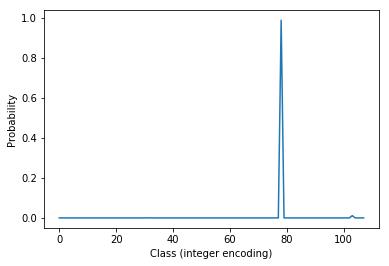

In [16]:
argmax_prediction = prediction.argmax(axis=-1)[0]
print('Maximal classifcation probability with value {:.4f} for class {}'.format(prediction[0][argmax_prediction],
                                                                          numerical_to_text_label[argmax_prediction]))
plt.plot(prediction[0])
plt.xlabel('Class (integer encoding)')
plt.ylabel('Probability')
plt.show()

***In summary***: All of these steps - isotropic scaling, descriptor calculation, neural network predictions (classification probabilities + uncertainty) - are summarized in the following funciton, to provide a quick and easy usage:

In [17]:
from ai4materials.models import AI_SYM

geometry_files = [os.path.join(prototype_path,
                              'Elemental_solids',
                              'fcc_Cu_A_cF4_225_a',
                              'fcc_Cu_A_cF4_225_a.txt' ),
                 os.path.join(prototype_path,
                              'Elemental_solids',
                              'bcc_W_A_cI2_229_a',
                              'bcc_W_A_cI2_229_a.txt' )]

predictions, uncertainty = AI_SYM.global_(geometry_files, logger=logger)

INFO: Metadata for descriptor quippy_SOAP_descriptor: [u'quippy_SOAP', u'quippy_SOAP_image', u'quippy_SOAP_coordinates']
INFO: Metadata for descriptor quippy_SOAP_descriptor: [u'quippy_SOAP', u'quippy_SOAP_image', u'quippy_SOAP_coordinates']
INFO: Structure: Atoms(symbols='Cu', pbc=True, cell=[[0.0, 1.807455, 1.807455], [1.807455, 0.0, 1.807455], [1.807455, 1.807455, 0.0]])
INFO: Structure: Atoms(symbols='Cu', pbc=True, cell=[[0.0, 1.807455, 1.807455], [1.807455, 0.0, 1.807455], [1.807455, 1.807455, 0.0]])


Atoms(symbols='Cu', pbc=True, cell=[[0.0, 1.807455, 1.807455], [1.807455, 0.0, 1.807455], [1.807455, 1.807455, 0.0]])
[ True  True  True]


INFO: Scale factor: 2.56112737438
INFO: Scale factor: 2.56112737438
INFO: Calculating classification uncertainty.
INFO: Calculating classification uncertainty.
INFO: Performing forward pass: 1/1000
INFO: Performing forward pass: 1/1000
INFO: Performing forward pass: 102/1000
INFO: Performing forward pass: 102/1000
INFO: Performing forward pass: 203/1000
INFO: Performing forward pass: 203/1000


2.561127374379063


INFO: Performing forward pass: 304/1000
INFO: Performing forward pass: 304/1000
INFO: Performing forward pass: 405/1000
INFO: Performing forward pass: 405/1000
INFO: Performing forward pass: 506/1000
INFO: Performing forward pass: 506/1000
INFO: Performing forward pass: 607/1000
INFO: Performing forward pass: 607/1000
INFO: Performing forward pass: 708/1000
INFO: Performing forward pass: 708/1000
INFO: Performing forward pass: 809/1000
INFO: Performing forward pass: 809/1000
INFO: Performing forward pass: 910/1000
INFO: Performing forward pass: 910/1000
INFO: Structure: Atoms(symbols='W', pbc=True, cell=[[-1.5775, 1.5775, 1.5775], [1.5775, -1.5775, 1.5775], [1.5775, 1.5775, -1.5775]])
INFO: Structure: Atoms(symbols='W', pbc=True, cell=[[-1.5775, 1.5775, 1.5775], [1.5775, -1.5775, 1.5775], [1.5775, 1.5775, -1.5775]])


Atoms(symbols='W', pbc=True, cell=[[-1.5775, 1.5775, 1.5775], [1.5775, -1.5775, 1.5775], [1.5775, 1.5775, -1.5775]])
[ True  True  True]


INFO: Scale factor: 2.73731014894
INFO: Scale factor: 2.73731014894
INFO: Calculating classification uncertainty.
INFO: Calculating classification uncertainty.
INFO: Performing forward pass: 1/1000
INFO: Performing forward pass: 1/1000
INFO: Performing forward pass: 102/1000
INFO: Performing forward pass: 102/1000
INFO: Performing forward pass: 203/1000
INFO: Performing forward pass: 203/1000
INFO: Performing forward pass: 304/1000
INFO: Performing forward pass: 304/1000


2.737310148939904


INFO: Performing forward pass: 405/1000
INFO: Performing forward pass: 405/1000
INFO: Performing forward pass: 506/1000
INFO: Performing forward pass: 506/1000
INFO: Performing forward pass: 607/1000
INFO: Performing forward pass: 607/1000
INFO: Performing forward pass: 708/1000
INFO: Performing forward pass: 708/1000
INFO: Performing forward pass: 809/1000
INFO: Performing forward pass: 809/1000
INFO: Performing forward pass: 910/1000
INFO: Performing forward pass: 910/1000


Similarly, one can print out the prediction and uncertainty information using the function 'analyze_predictions':

In [18]:
AI_SYM.analyze_predictions(geometry_files, predictions, uncertainty)

For geometry file ./geometry_files/single_crystals/AI_SYM_paper/PROTOTYPES/Elemental_solids/fcc_Cu_A_cF4_225_a/fcc_Cu_A_cF4_225_a.txt
1. Predicted prototype fcc_Cu_A_cF4_225_a with classification probability 0.9500
2. Predicted prototype bctIn_In_A_tI2_139_a with classification probability 0.0447
3. Predicted prototype L12_Cu3Au with classification probability 0.0029
Uncertainty: variation_ratio = 0.021 mutual_information = 0.1314 predictive_entropy = 0.3221 
For geometry file ./geometry_files/single_crystals/AI_SYM_paper/PROTOTYPES/Elemental_solids/bcc_W_A_cI2_229_a/bcc_W_A_cI2_229_a.txt
1. Predicted prototype bcc_W_A_cI2_229_a with classification probability 0.9874
2. Predicted prototype stetBetaNp_Np_A_tP4_129_ac with classification probability 0.0126
3. Predicted prototype diam_C_A_cF8_227_a with classification probability 0.0000
Uncertainty: variation_ratio = 0.005 mutual_information = 0.0523 predictive_entropy = 0.0985 


As discussed in [1], the great advantage of our method is that we can treat much more classes than available methods.

Considering as an example binary structures, specifically NaCl, we have to think a little bit to obtain a descriptor that fits the input  of the model. What we mean by that is that the usual way in treating multiple chemical species is to calculate

$\begin{equation}
p(\mathscr{X})_{b_1b_2l}^{\alpha\beta}=\pi\sqrt{\frac{8}{2l+1}}\sum_{m}(c_{b_1 lm}^{\alpha})^{\dagger} c_{b_2 lm}^\beta.
\end{equation}$

Then one may simply append all of these components, or average over certain combinations. We take the latter rout, where it turns out that it suffices (for our purposes) to only select coefficients for $Z_1 = Z_2$ and ignore cross terms for $Z_1 \neq Z_2$. Then, we consider all substructures, i.e., we compute SOAP according to 

$\begin{equation}
 p(\mathscr{X})_{b_1b_2l}=\pi\sqrt{\frac{8}{2l+1}}\sum_{m}(c_{b_1 lm})^{\dagger} c_{b_2 lm}. \label{equation:SOAP_power_spectrum}
\end{equation}$

where we sit on all Na atoms and consider only Na atoms or Ca atoms, and sit on all Ca atoms and consider only all Ca or Na atoms. This gives us 4 vectors, which we average. Generalization to structures with arbitrary number of chemical species is straightforward - and so we end up with a descriptor that is independent on 1. the number of atoms, 2. number of chemical species, and 3. incorporates all relevant symmetries (rotational invariance, translational invariance, and invariance with respect to permutations of identical atoms).

Coming back to our implementation, one only has to provide one additional keyword 'scale_elment_sensitive' and set it  to 'True' - this way, we isotropically scale each substructure separately (one may also not do this, but the model we provide her is not trained on this kind of procedure):

In [20]:
geometry_files = [NaCl_prototype_path]
#view(structure, viewer='x3d')

In [ ]:
predictions, uncertainty = AI_SYM.global_(geometry_files, logger=logger)

In [ ]:
AI_SYM.analyze_predictions(geometry_files, predictions, uncertainty)

For the predictions in the fccm we see that non-zero probabiltiy is also assigned to another prototype, which is the following one

In [38]:
print('Further candidate: classifcation probability with value {} for class {}'.format(prediction[0][81],
                                                                          numerical_to_text_label[81]))

Further candidate: classifcation probability with value 1.58886653834e-10 for class bctIn_In_A_tI2_139_a


This assignment is justified since it is a slightly distorted (tetragonal) version of fcc (http://aflowlib.org/prototype-encyclopedia/A_tI2_139_a.In.html).

We also see the uncertainty is non-zero, indicating that there might be multiple candidates. Specifically, the mutual information (see ? for the exact definition) has the value

In [15]:
print(uncertainty['mutual_information'][0])

0.12248099


There are also other ways to quantify the uncertainty (see for instance L. Smith & Y. Gal, arXiv:1803.08533v1, 2018), where the function 'predict_with_uncertainty' automatically calculates mutual information, predictive enetropy, and variation ratio:

In [16]:
for uncertainty_type in uncertainty:
    print('For uncertainty {}, observe value of {}'.format(uncertainty_type, uncertainty[uncertainty_type][0]))

For uncertainty variation_ratio, observe value of 0.019
For uncertainty mutual_information, observe value of 0.122480988503
For uncertainty predictive_entropy, observe value of 0.307086288929


In [ ]:
# Parallel processsing: demonstrate that it is much faster - see last two
# cells of https://colab.research.google.com/github/Stable-Baselines-Team/rl-colab-notebooks/blob/master/multiprocessing_rl.ipynb

In [71]:
prototypes_path = prototype_path
datasets = os.listdir(prototypes_path)
min_nb_atoms = 100
p_b_c = True
all_prototypes = defaultdict(list)
    
for dataset in datasets:
    #if not dataset=='2D_materials':
    #    continue
    # skip Nanotubes if pbc True
    # NOT DO THE FOLLOWING
    #if p_b_c==True and dataset=='Nanotubes':
    #    continue
    # because it will skip nanotubes and then only return 96 instead of 108 classes
    # which we do not want
    #if not dataset=='Elemental_solids':
    #    continue

    prototypes_basedir = os.path.join(prototypes_path,dataset)
    crystal_structures = os.listdir(prototypes_basedir)

    # LOAD PROTOTYPES
    # go trhough folder, get all txt files, load all of protos, give them labels according to their filename which will identify them uniquely  
    prototypes = []
    for crystal_structure in crystal_structures:
        all_files = os.listdir(os.path.join(prototypes_basedir, crystal_structure))
        all_files = [x for x in all_files if x[-4:]=='.txt'] # only consider txt files
        for i,filename in enumerate(all_files):
            prototype = ase.io.read(os.path.join(prototypes_basedir,crystal_structure,filename), ':', 'aims')[0]
            prototype.info['idx'] = i
            prototype.info['label'] = filename[:-4] # label for assigning unique name to all files in the tar files
            prototype.info['crystal_structure'] = crystal_structure # THIS WILL BE USED AS TARGET FOR TRAINING
            prototype.info['dataset'] = dataset
            # get supercell size - replicate unit cell until min_nb_atoms is exceeded
            if dataset=='2D_materials': # for 2D materials only replicate in x and y
                replica = 0
                while (prototype*(replica,replica,1)).get_number_of_atoms()<min_nb_atoms:
                    replica+=1
                supercell_list = []
                for x in [replica, replica+1, replica+2]:
                    for y in [replica, replica+1, replica+2]:
                        supercell_list.append((x,y,1))
                prototype.info['supercells'] = [(x,x,1) for x in [replica, replica+1, replica+2]] # supercell_list
            elif dataset=='Nanotubes':
                prototype.info['supercells'] = ['Nanotubes']
            else:
                replica = 0
                while (prototype*(replica,replica,replica)).get_number_of_atoms()<min_nb_atoms:
                    replica+=1
                supercell_list = []
                for x in [replica,replica+1]:
                    for y in [replica, replica+1]:
                        for z in [replica, replica+1]:
                            supercell_list.append((x,y,z))
                prototype.info['supercells'] = [(x,x,x) for x in [replica,replica+1, replica+2]] # supercell_list                    
                #prototype.info['supercells'].append(['cubic_shape_1','cubic_shape_2'])

            # channged to fit in pbc=True
            #prototype.set_pbc(False)
            if dataset=='Nanotubes':
                prototype.set_pbc(False)
            elif dataset=='2D_materials':
                prototype.set_pbc([p_b_c,p_b_c,False])
            else:
                prototype.set_pbc(p_b_c)
            prototypes.append(prototype)
            all_prototypes[dataset].append(prototype)

In [75]:
import multiprocessing
max_nb_CPUs = multiprocessing.cpu_count()

print('You have a maximum of {} CPUs available.'.format(max_nb_CPUs))


from ai4materials.wrappers import calc_descriptor_in_memory
descriptor_to_calculate = 'SOAP'
extrinsic_scaling_factor = 1.0
prototypes_pristine = all_prototypes['Elemental_solids']
target_list_pristine = [_.info['crystal_structure'] for _ in prototypes_pristine]
dataset = '_'.join(datasets)


desc_file_name=dataset+'_'+descriptor_to_calculate+'_pristine_cutoff_'+str(round(cutoff,4))+'_atom_sigma_'+str(round(atom_sigma,4))+'_exsf_'+str(extrinsic_scaling_factor)+'_pbc_'+str(p_b_c)+'.tar.gz'


nb_jobs_list = [1, max_nb_CPUs]
computation_times = {}

You have a maximum of 8 CPUs available.


In [77]:
# Set logger to lowest level, otherwise get too much messages
logger.setLevel(0)

for nb_jobs in nb_jobs_list:

    start = timer()
    desc_file_path = calc_descriptor_in_memory(descriptor=descriptor, configs=configs, ase_atoms_list=prototypes_pristine,
                                     tmp_folder=configs['io']['tmp_folder'],
                                     desc_folder=configs['io']['desc_folder'],
                                     desc_file=desc_file_name,
                                     format_geometry='`aims',
                                     nb_jobs=nb_jobs,
                                     target_list = target_list_pristine)
    end = timer()
    print('Paralleization to {} CPUs results in computation time of {}'.format(nb_jobs, end - start))
    computation_times[nb_jobs] = end - start
    
print(computation_times)

  4%|▎         | 1/27 [00:00<00:04,  5.25it/s]

[ True  True  True]
1.0968244409968257
[ True  True  True]


  7%|▋         | 2/27 [00:00<00:04,  5.69it/s]

2.373197167949473
[ True  True  True]


 11%|█         | 3/27 [00:00<00:04,  4.98it/s]

1.2301166000004353
[ True  True  True]


 19%|█▊        | 5/27 [00:01<00:05,  4.05it/s]

1.4229722627107249
[ True  True  True]
3.0274581528326383
[ True  True  True]


 22%|██▏       | 6/27 [00:01<00:05,  4.12it/s]

2.4839579308223283
[ True  True  True]


 26%|██▌       | 7/27 [00:01<00:04,  4.22it/s]

2.561127374379063
[ True  True  True]
3.73278576713622


 30%|██▉       | 8/27 [00:01<00:04,  4.34it/s]

[ True  True  True]


 37%|███▋      | 10/27 [00:02<00:03,  4.45it/s]

3.026092374352882
[ True  True  True]
2.9913011547970125
[ True  True  True]


 44%|████▍     | 12/27 [00:02<00:03,  4.32it/s]

1.5115062686593133
[ True  True  True]
3.3449999999999998
[ True  True  True]


 48%|████▊     | 13/27 [00:03<00:03,  4.31it/s]

2.737310148939904
[ True  True  True]


 56%|█████▌    | 15/27 [00:03<00:02,  4.43it/s]

3.588158626577667
[ True  True  True]
3.222370510214825
[ True  True  True]


 59%|█████▉    | 16/27 [00:03<00:02,  4.53it/s]

3.2578300000000002
[ True  True  True]


 67%|██████▋   | 18/27 [00:03<00:01,  4.65it/s]

2.5213801683894754
[ True  True  True]
2.99060000000076
[ True  True  True]


 70%|███████   | 19/27 [00:04<00:01,  4.70it/s]

3.2019970680826146
[ True  True  True]


 74%|███████▍  | 20/27 [00:04<00:01,  4.30it/s]

1.5323942302293536
[ True  True  True]


 81%|████████▏ | 22/27 [00:05<00:01,  4.33it/s]

2.2285996706111826
[ True  True  True]
2.716954861847056
[ True  True  True]


 85%|████████▌ | 23/27 [00:05<00:00,  4.44it/s]

3.3639980892191517
[ True  True  True]


 89%|████████▉ | 24/27 [00:05<00:00,  4.27it/s]

1.4275910632832258
[ True  True  True]
2.747530068303571


 93%|█████████▎| 25/27 [00:05<00:00,  4.31it/s]

[ True  True  True]
2.758500045314285


 96%|█████████▋| 26/27 [00:06<00:00,  4.32it/s]

[ True  True  True]


100%|██████████| 27/27 [00:06<00:00,  4.19it/s]

1.5421950917173786


Paralleization to 1 CPUs results in computation time of 9.1417529583
[ True  True  True]
[ True  True  True]
[ True  True  True]
[ True  True  True]


  0%|          | 0.00/27.0 [00:00<?, ?it/s]

[ True  True  True]
[ True  True  True]
[ True  True  True]
[ True  True  True]
1.0968244409968257
3.73278576713622
3.0274581528326383


  4%|▎         | 1.00/27.0 [00:00<00:08, 3.20it/s]

[ True  True  True]
2.373197167949473
[ True  True  True]
[ True  True  True]
2.4839579308223283


 15%|█▍        | 4.00/27.0 [00:00<00:02, 8.11it/s]

[ True  True  True]
2.561127374379063
[ True  True  True]
3.026092374352882


 22%|██▏       | 6.00/27.0 [00:00<00:02, 9.03it/s]

[ True  True  True]
2.9913011547970125
3.3449999999999998


 26%|██▌       | 7.00/27.0 [00:00<00:02, 8.81it/s]

[ True  True  True]
1.2301166000004353
[ True  True  True]


 33%|███▎      | 9.00/27.0 [00:00<00:01, 9.66it/s]

[ True  True  True]
[ True  True  True]
3.222370510214825
1.4229722627107249


 41%|████      | 11.0/27.0 [00:01<00:01, 9.57it/s]

[ True  True  True]
3.2578300000000002


 44%|████▍     | 12.0/27.0 [00:01<00:01, 9.55it/s]

2.737310148939904
[ True  True  True]
2.5213801683894754
[ True  True  True]
3.588158626577667
2.99060000000076


 52%|█████▏    | 14.0/27.0 [00:01<00:01, 9.85it/s]

[ True  True  True]
1.5115062686593133
[ True  True  True]


 59%|█████▉    | 16.0/27.0 [00:01<00:01, 10.1it/s]

[ True  True  True]
[ True  True  True]
3.2019970680826146
[ True  True  True]
2.716954861847056


 70%|███████   | 19.0/27.0 [00:01<00:00, 10.7it/s]

3.3639980892191517
[ True  True  True]


 78%|███████▊  | 21.0/27.0 [00:01<00:00, 10.8it/s]

2.747530068303571
2.2285996706111826


 85%|████████▌ | 23.0/27.0 [00:02<00:00, 10.8it/s]

2.758500045314285
1.4275910632832258


 93%|█████████▎| 25.0/27.0 [00:02<00:00, 10.3it/s]

1.5421950917173786
1.5323942302293536


100%|██████████| 27.0/27.0 [00:02<00:00, 9.64it/s]
27it [00:00, 112014.05it/s]


Paralleization to 8 CPUs results in computation time of 5.5902531147
{8: 5.590253114700317, 1: 9.14175295829773}


In [76]:
TODO: need to tune which datasets to choose
    + how much cpus are actually employed.

## Single crystals - experimental section

# Polycyrstal classification

# Unsupervised analysis

## Reload and inspect data

Idea is that one can get a feeling for the most important parameters in HDBSCAN and UMAP, which are n_neighbors and min_cluster_size. Then use a simple slider to go through values

In [10]:
n_neighbors_list = [25, 50, 100, 250, 1000] 
min_cluster_sizes = n_neighbors_list

In [3]:
from ipywidgets import interact
def f(x):
    return x

In [4]:
interact(f, x=10)

interactive(children=(IntSlider(value=10, description=u'x', max=30, min=-10), Output()), _dom_classes=('widget-interact',))

<function __main__.f>

In [14]:
# other good resource: https://towardsdatascience.com/interactive-controls-for-jupyter-notebooks-f5c94829aee6

%matplotlib inline
from ipywidgets import interactive
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

n_neighbors_list = [25, 50, 100, 250, 1000] 
min_cluster_sizes = n_neighbors_list

analysis_folder_path = './unsupervised_learning/polycrystal_data'
file_name = 'four_grains_elemental_solid.xyz_stride_1.0_1.0_16.0_box_size_16.0_.tar.gz_'
layer_name = 'dense_1'
s = 32
edgecolors = 'face'

df_dict = {}

for min_cluster_size in min_cluster_sizes:
    for n_neighbors in n_neighbors_list:

        quantities_to_plot = {#'cluster_probs': [],
                              #'outlier_scores': [],
                              'cluster_labels': [], 'embedding' : []
                              #'argmax_clustering': [], 
                            }
        for q_to_plot in quantities_to_plot:
            q = quantities_to_plot[q_to_plot]
            q_filename =  os.path.join(analysis_folder_path,
                                          file_name 
                                          + '_' 
                                          + layer_name 
                                          + '_mincsize_'
                                          + str(min_cluster_size) 
                                          + '_nneighbors_'
                                          + str(n_neighbors)
                                          + '_' + q_to_plot + '.npy')
            quantities_to_plot[q_to_plot] = np.load(q_filename)
        embedding = quantities_to_plot['embedding']
        #print(embedding.shape)
        #print(quantities_to_plot['cluster_labels'].shape)
        df = pd.DataFrame({'Dim_1': embedding[:, 0], 'Dim_2': embedding[:, 1], 'target':quantities_to_plot['cluster_labels']})
        df_dict[(min_cluster_size, n_neighbors)] = df
def f(min_cluster_size, n_neighbors):
    df = df_dict[(min_cluster_size, n_neighbors)]
    
    fig, ax = plt.subplots(figsize=(10,10))
    ax_ = sns.scatterplot(ax=ax, x='Dim_1', y='Dim_2', data=df, s=s, hue='target', edgecolor=edgecolors)
    plt.legend()
    plt.show()
    
    

interactive_plot = interactive(f, min_cluster_size=min_cluster_sizes,
                               n_neighbors=n_neighbors_list)
output = interactive_plot.children[-1]
output.layout.height = '350px'
interactive_plot



interactive(children=(Dropdown(description=u'min_cluster_size', options=(25, 50, 100, 250, 1000), value=25), Dropdown(description=u'n_neighbors', options=(25, 50, 100, 250, 1000), value=25), Output(layout=Layout(height=u'350px'))), _dom_classes=('widget-interact',))

## Visualizing and intepreting dimensionality reduced plots (here: UMAP)

In [ ]:
# good resource seemingly: https://observablehq.com/@grantcuster/using-three-js-for-2d-data-visualization
# https://grantcuster.github.io/umap-explorer/#about
# https://umap-learn.readthedocs.io/en/latest/interactive_viz.html

# Creating and training your own model

# Conclusion

You have reached the end of this tutorial. 

*Please let us know if you have any questions, wishes, or suggestions for improvement. Feel free to reach us by mail (leitherer@fhi-berlin.mpg.de, andreas.leitherer@gmail.com).*

# References

[1] ARISE: A. Leitherer, A. Ziletti, M. Scheffler, and L. M. Ghiringhelli, arxiV:??, (2021)

[2] ai4materials: A. Leitherer, A.Ziletti, and L. M. Ghiringhelli, https://joss.theoj.org/papers ?

[3] A. P. Bartok et al. Physical Review Letters 104 136403 (2010)

[4] A. P. Bartok et al. Physical Review B 87 184115 (2013)

[5] The quippy software is available for non-commercial use from www.libatoms.org (or https://github.com/libAtoms/QUIP)
